In [1]:
from __future__ import division

In [2]:
import numpy as np
import pandas as pd 
import xgboost 
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import learning_curve
from time import time
from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('kc_house_data.csv')
df_train=data.copy()
df_train.rename(columns={'price':'saleprice'}, inplace=True)
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
print(len(data))

21613


In [5]:
print(data.isnull().any().sum(),'/', len(data.columns))

0 / 21


In [6]:
print(data.isnull().any(axis=1).sum(),'/', len(data.columns))

0 / 21


In [7]:
features=data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [8]:
correlations={}
for f in features:
    data_temp= data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + 'vs'+ target
    correlations[key] = pearsonr(x1,x2)[0]
    print (correlations)

{'bedroomsvsprice': 0.3083495981456383}
{'bedroomsvsprice': 0.3083495981456383, 'bathroomsvsprice': 0.5251375054139618}
{'bedroomsvsprice': 0.3083495981456383, 'bathroomsvsprice': 0.5251375054139618, 'sqft_livingvsprice': 0.7020350546118}
{'bedroomsvsprice': 0.3083495981456383, 'bathroomsvsprice': 0.5251375054139618, 'sqft_livingvsprice': 0.7020350546118, 'sqft_lotvsprice': 0.08966086058710013}
{'bedroomsvsprice': 0.3083495981456383, 'bathroomsvsprice': 0.5251375054139618, 'sqft_livingvsprice': 0.7020350546118, 'sqft_lotvsprice': 0.08966086058710013, 'floorsvsprice': 0.2567938875507184}
{'bedroomsvsprice': 0.3083495981456383, 'bathroomsvsprice': 0.5251375054139618, 'sqft_livingvsprice': 0.7020350546118, 'sqft_lotvsprice': 0.08966086058710013, 'floorsvsprice': 0.2567938875507184, 'waterfrontvsprice': 0.2663694340306021}
{'bedroomsvsprice': 0.3083495981456383, 'bathroomsvsprice': 0.5251375054139618, 'sqft_livingvsprice': 0.7020350546118, 'sqft_lotvsprice': 0.08966086058710013, 'floorsvsp

In [9]:
data_correlations=pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_livingvsprice,0.702035
gradevsprice,0.667434
sqft_abovevsprice,0.605567
sqft_living15vsprice,0.585379
bathroomsvsprice,0.525138
viewvsprice,0.397293
sqft_basementvsprice,0.323816
bedroomsvsprice,0.308350
latvsprice,0.307003
waterfrontvsprice,0.266369


<Axes: xlabel='sqft_living15', ylabel='price'>

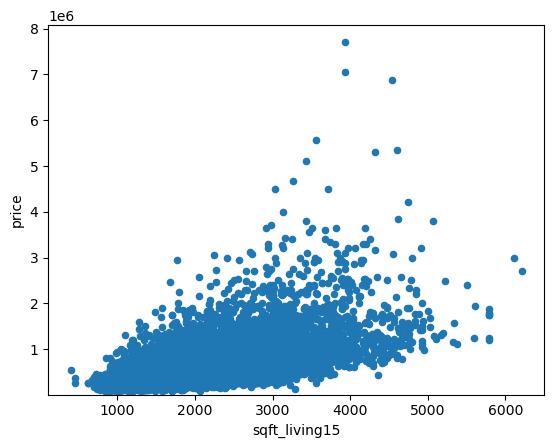

In [10]:
var = 'sqft_living15'
data = pd.concat([data['price'], data[var]], axis = 1)
data.plot.scatter(x = var, y='price', ylim=(5000))

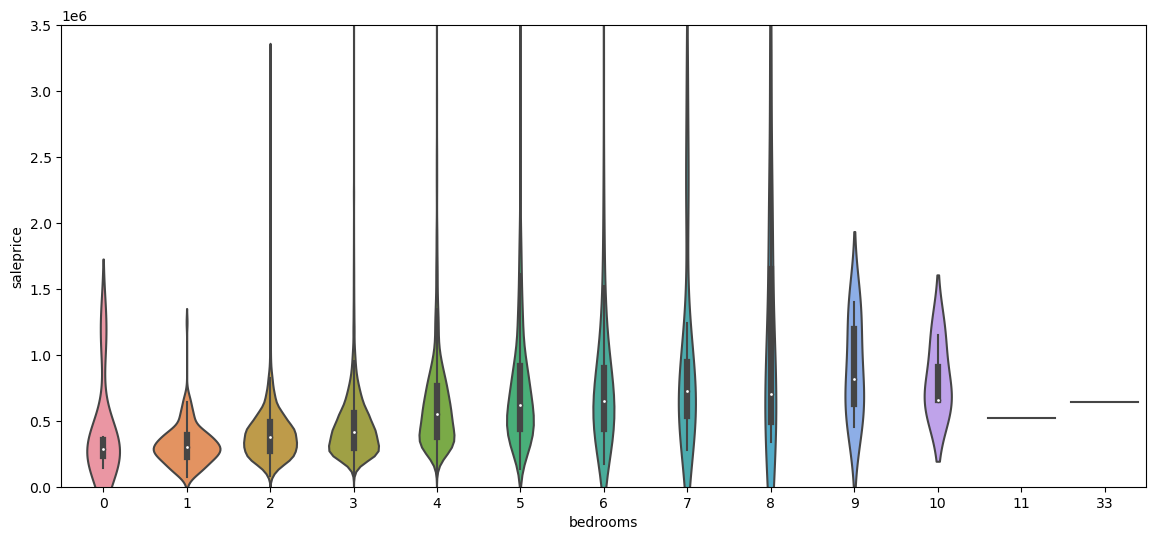

In [11]:
var='bedrooms'
data = pd.concat([df_train['saleprice'], df_train[var]], axis = 1)
f, ax=plt.subplots(figsize = (14, 6))
fig = sns.violinplot(x = var, y="saleprice", data = data)
fig.axis(ymin = 0, ymax = 3500000);

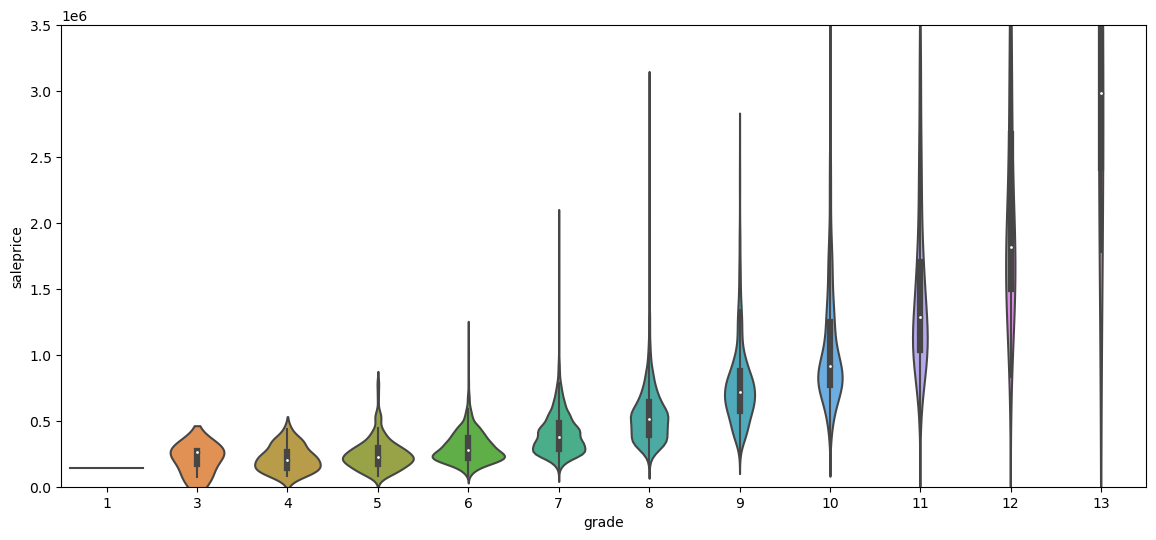

In [12]:
var='grade'
data =pd.concat([df_train['saleprice'], df_train[var]], axis=1)
f, ax=plt.subplots(figsize=(14, 6))
fig= sns.violinplot(x=var, y="saleprice", data=data)
fig.axis(ymin=0, ymax=3500000);

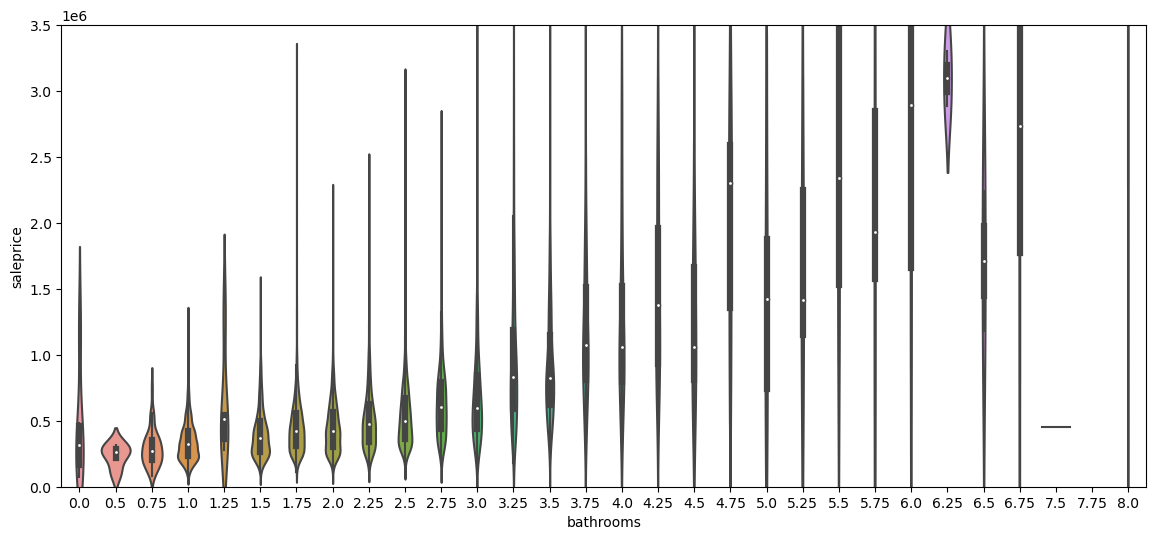

In [13]:
var='bathrooms'
data =pd.concat([df_train['saleprice'], df_train[var]], axis=1)
f, ax=plt.subplots(figsize=(14, 6))
fig= sns.violinplot(x=var, y="saleprice", data=data)
fig.axis(ymin=0, ymax=3500000);

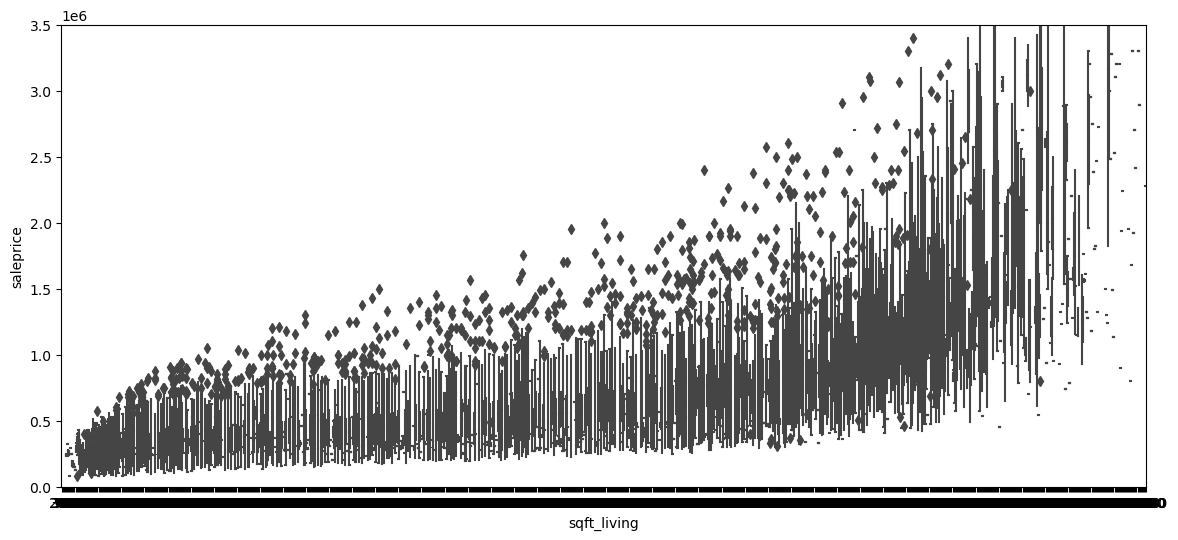

In [14]:
var='sqft_living'
data =pd.concat([df_train['saleprice'], df_train[var]], axis=1)
f, ax=plt.subplots(figsize=(14, 6))
fig= sns.boxplot(x=var, y="saleprice", data=data)
fig.axis(ymin=0, ymax=3500000);

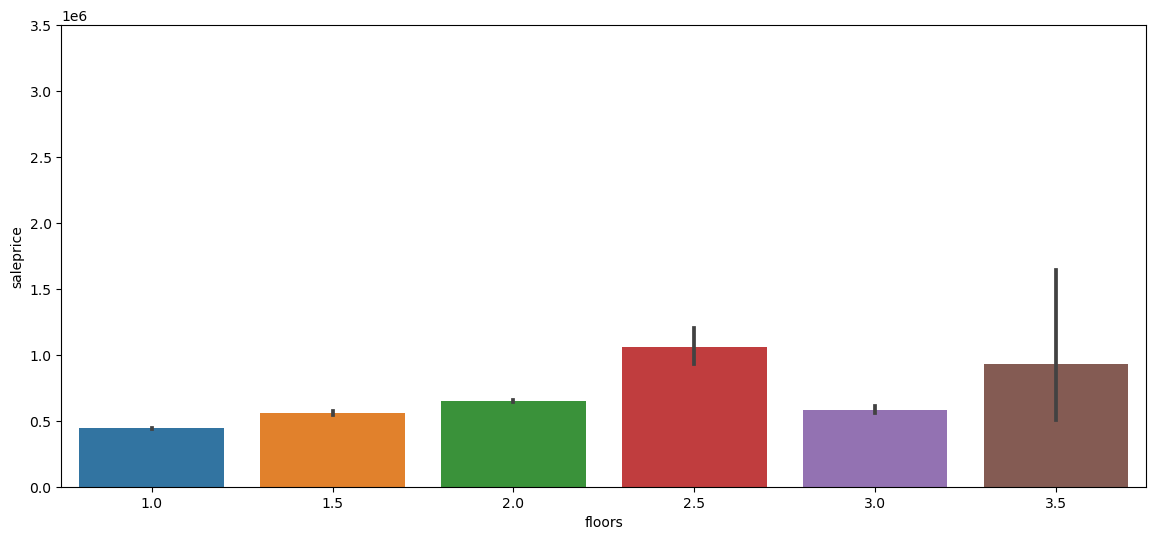

In [15]:
var='floors'
data =pd.concat([df_train['saleprice'], df_train[var]], axis=1)
f, ax=plt.subplots(figsize=(14, 6))
fig= sns.barplot(x=var, y="saleprice", data=data)
fig.axis(ymin=0, ymax=3500000);

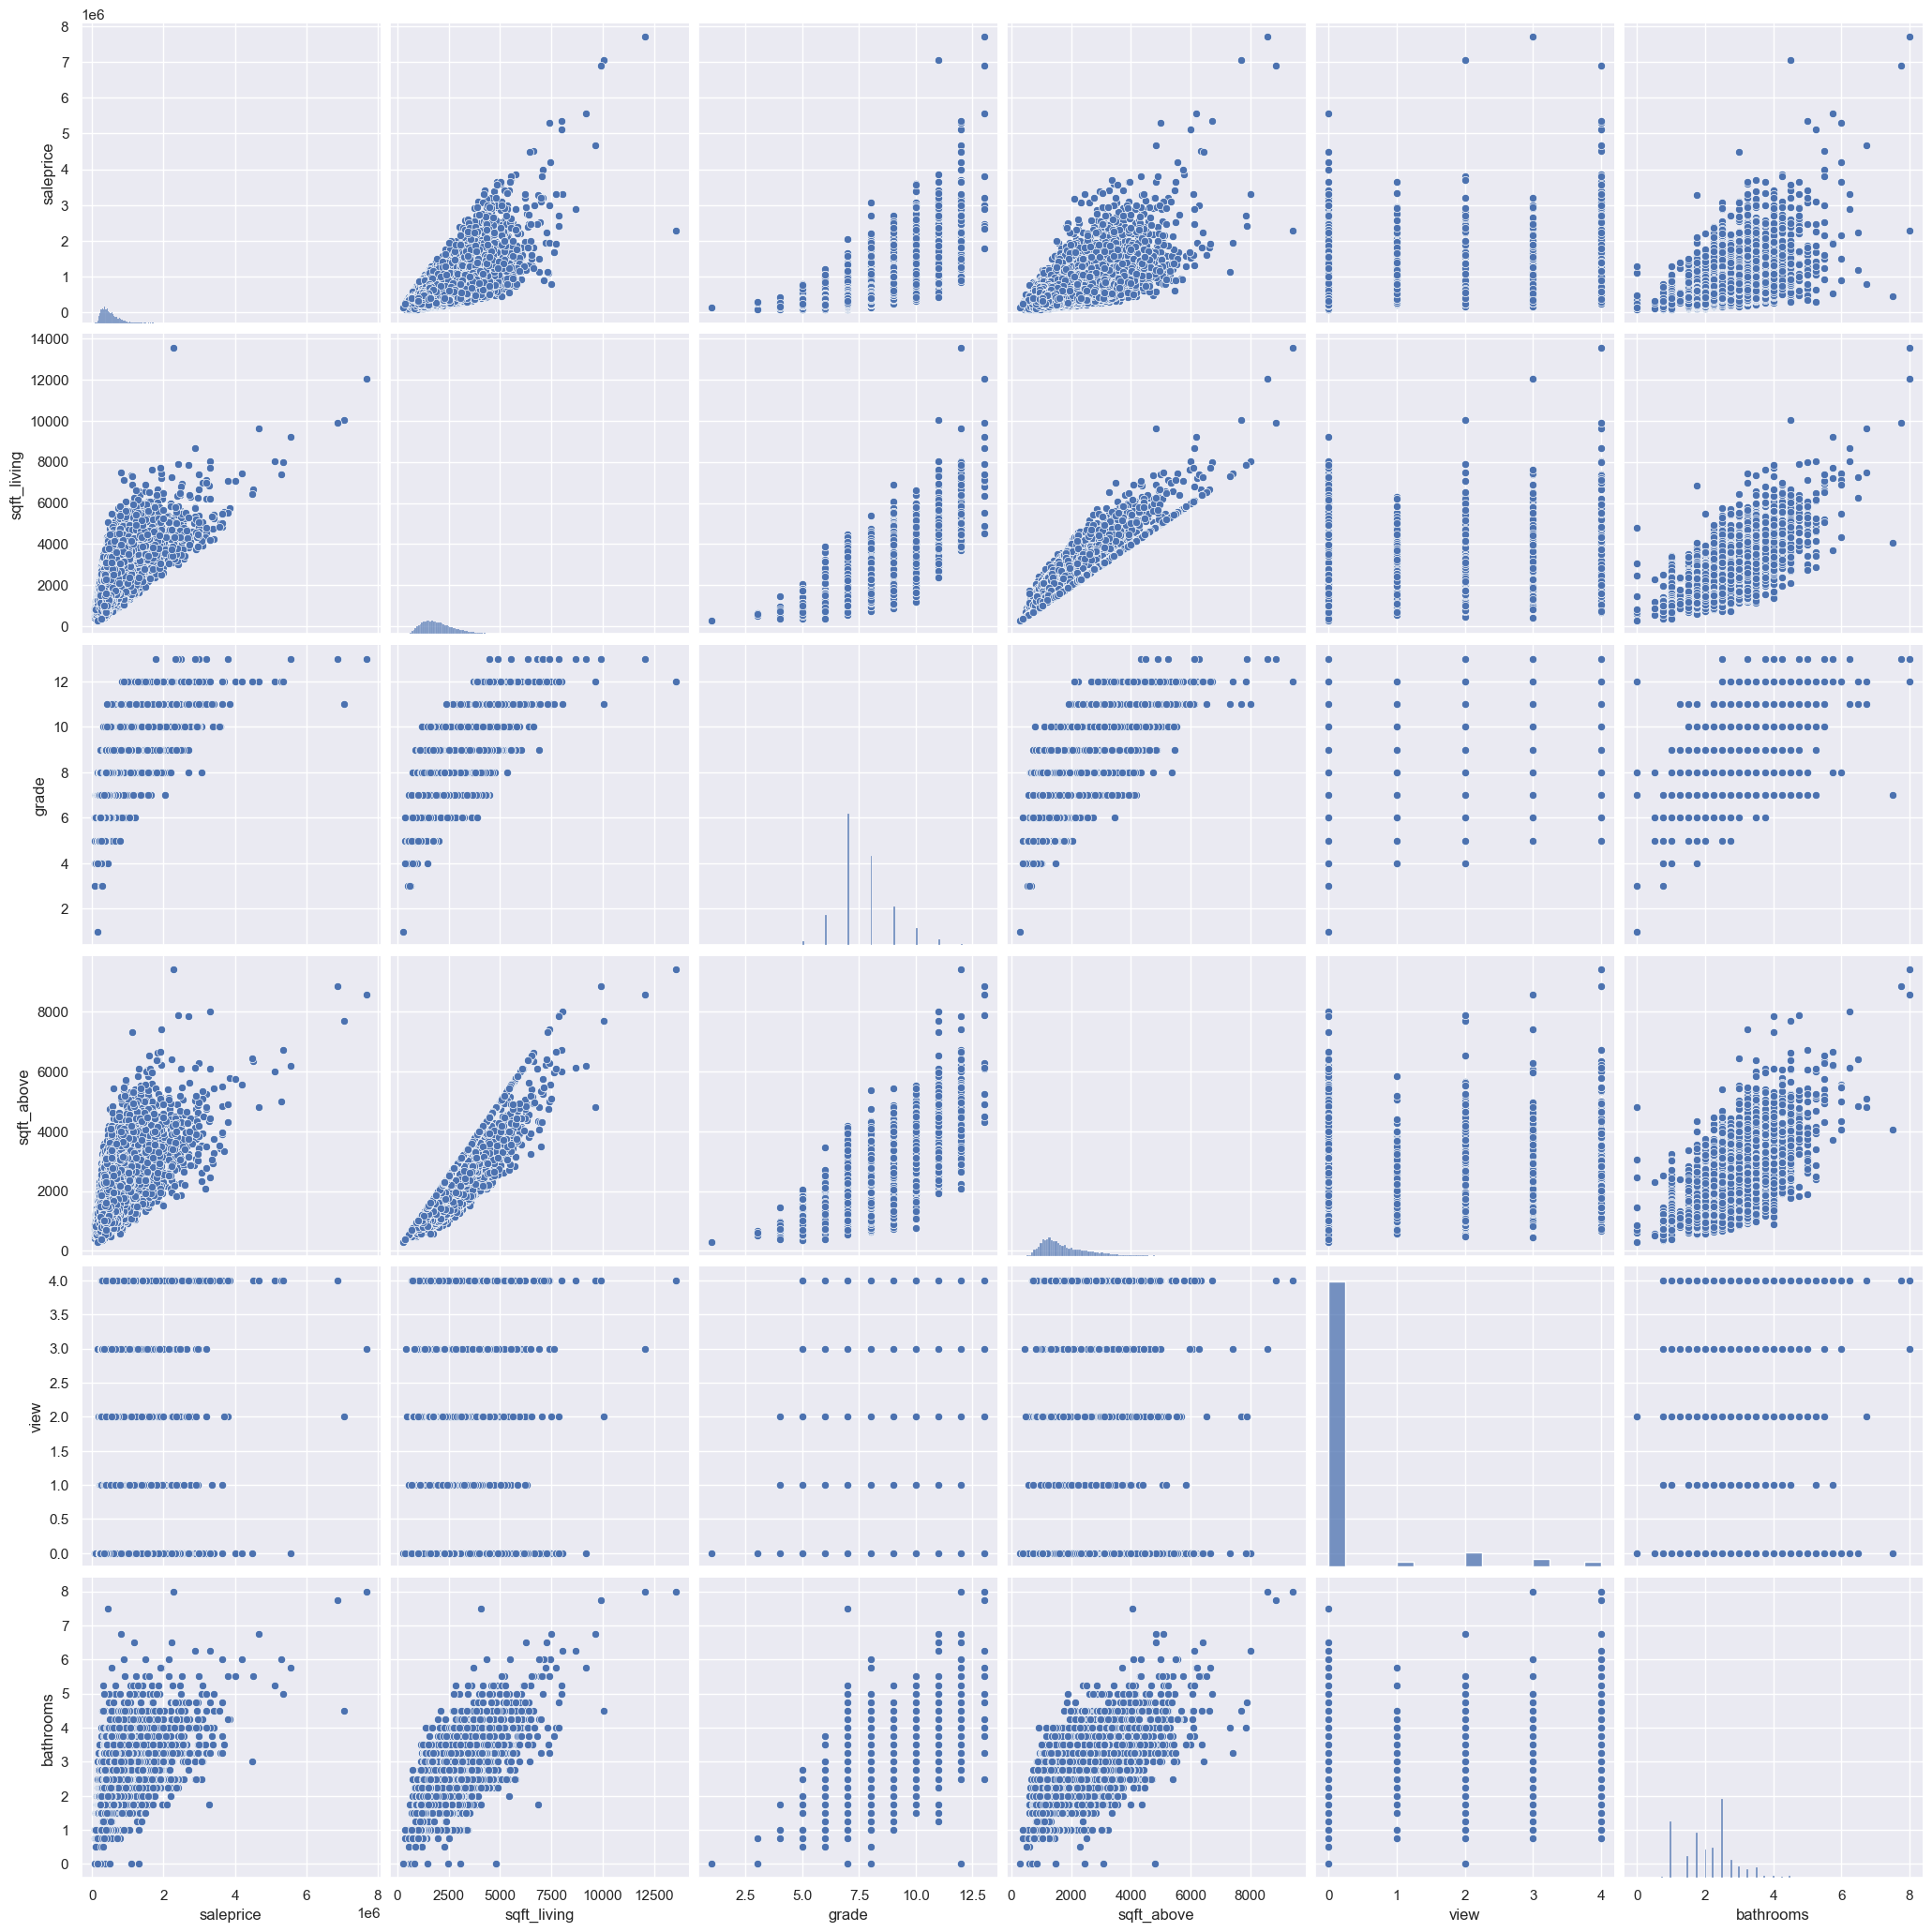

In [16]:
sns.set()
cols = ['saleprice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms']
sns.pairplot(df_train[cols], height=3.5)
plt.show();

In [17]:
new_data= df_train[['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']]
X = new_data.values
y=df_train.saleprice.values

In [18]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [19]:
from sklearn.ensemble import RandomForestRegressor
rand_regr = RandomForestRegressor(n_estimators=500, random_state=0)
start = time()
rand_regr.fit(X_train, y_train)
end = time()
train_time_rand=end-start
random=rand_regr.score(X_test, y_test)
predictions = rand_regr.predict(X_test)
exp_rand = explained_variance_score(predictions, y_test)
exp1 = r2_score(predictions, y_test)
print(train_time_rand, exp_rand, exp1)

64.20072054862976 0.3662053060678495 0.3661914877685668


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
start = time()
est = GradientBoostingRegressor(n_estimators=500, max_depth=5, loss='squared_error', min_samples_split=1000)
end = time()
train_time_g=end-start
est.fit(X_train, y_train)
gradient=est.score(X_test, y_test)
pred = est.predict(X_test)
exp_est = explained_variance_score(pred, y_test)
exp2 = r2_score(predictions, y_test)
print(train_time_g, gradient, exp_est, exp2)

0.0 0.6010459220594051 0.3826728214475229 0.3661914877685668


In [21]:
from sklearn.ensemble import AdaBoostRegressor
start = time()
est = AdaBoostRegressor(n_estimators=50, learning_rate=0.5, loss='exponential').fit(X_train, y_train)
end = time()
train_time_g1=end-start
gradient1=est.score(X_test, y_test)
pred = est.predict(X_test)
exp_est1 = explained_variance_score(pred, y_test)
exp3=r2_score(pred, y_test)
print(train_time_g1, gradient1, exp_est1, exp3)

0.9063458442687988 0.44137083036133606 0.4147381060562214 0.3203636787913273


In [22]:
from xgboost import XGBRegressor
start = time()
model = XGBRegressor(n_estimators=1000, learning_rate=0.25, loss='exponential').fit(X_train, y_train)
end = time()
train_time = end-start
grad= model.score(X_test, y_test)
pre= model.predict(X_test)
exp_model = explained_variance_score(pre, y_test)
exp4=r2_score(pre, y_test)
print(train_time, grad, exp_model, exp4)

C:\Users\91767\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


2.5566766262054443 0.5381483209258965 0.3731599366075087 0.3731511584523347


In [23]:
from sklearn.tree import DecisionTreeRegressor
start=time()
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)
end=time()
train_time_dt=end-start
reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)
exp_reg_tree = explained_variance_score(reg_tree_pred, y_test)
exp5 = r2_score(reg_tree_pred, y_test)
print(train_time_dt, exp_reg_tree, exp5)

0.005190849304199219 0.16309950642643867 0.16272652961465206


In [24]:
y_train

array([404000., 485000., 322500., ..., 353500., 386180., 410000.])

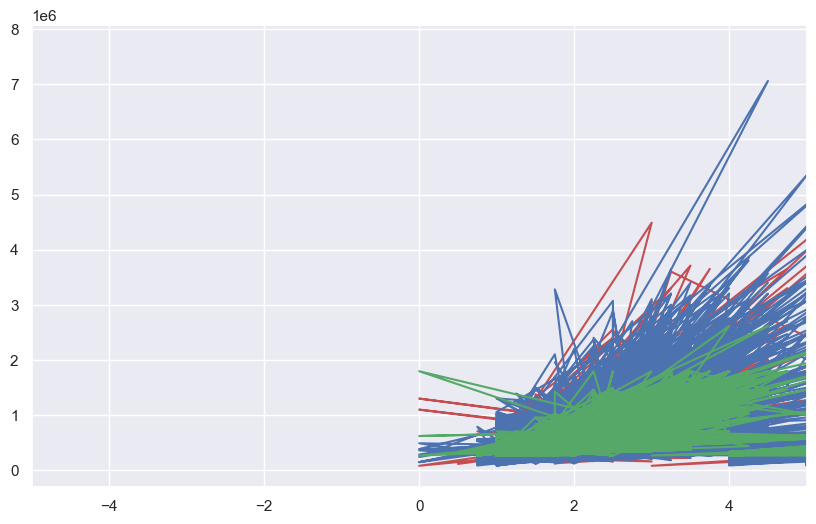

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, "r")
plt.plot(X_train, y_train, c="b")
plt.plot(X_test, reg_tree_pred, "g")
plt.xlim([-5, 5])
#plt.title( "Decision tree regressor, MSE = %.2f"   % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

In [26]:
!pip install lightgbm

In [27]:
from lightgbm import LGBMRegressor
start=time()
reg_tree = LGBMRegressor(learning_rate=0.2, max_depth=8)
end=time()
train_time_dt = end-start
reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)
exp_reg_tree = explained_variance_score(reg_tree_pred, y_test)
exp = r2_score(reg_tree_pred, y_test)
print(train_time_dt, exp_reg_tree, exp)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 16209, number of used features: 5
[LightGBM] [Info] Start training from score 540408.270714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [28]:
!pip install catboost
from catboost import CatBoostRegressor
start=time()
reg_tree = CatBoostRegressor(learning_rate=0.02, max_depth=8).fit(X_train, y_train)
end=time()
train_time_dt1 = end-start
reg_tree_pred = reg_tree.predict(X_test)
exp_reg_tree1 = explained_variance_score(reg_tree_pred, y_test)
exp7 = r2_score(reg_tree_pred, y_test)
print(train_time_dt1, exp_reg_tree1, exp7)

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
  Using cached catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata (1.2 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB 640.0 kB/s eta 0:02:38
   ---------------------------------------- 0.1/101.0 MB 656.4 kB/s eta 0:02:34
   ---------------------------------------- 0.1/101.0 MB 871.5 kB/s eta 0:01:56
   ---------------------------------------- 0.2/101.0 MB 1.3 MB/s eta 0:01:17
   ---------------------------------------- 0.2/101.0 MB 1.2 MB/s eta 0:01:27
   ---------------------------------------- 0.3/101.0 MB 1.3 MB/s eta 0:01:20
   ---------------------------------------- 0.4/101.0 MB 1.3 MB/s eta 0:01:17
   ----------------------------------

0:	learn: 365109.7516621	total: 167ms	remaining: 2m 46s
1:	learn: 361302.9592838	total: 179ms	remaining: 1m 29s
2:	learn: 357603.9587417	total: 190ms	remaining: 1m 2s
3:	learn: 354062.7782739	total: 199ms	remaining: 49.6s
4:	learn: 350550.5718943	total: 209ms	remaining: 41.5s
5:	learn: 347150.4787579	total: 218ms	remaining: 36.1s
6:	learn: 343893.4848890	total: 226ms	remaining: 32s
7:	learn: 340604.6174542	total: 234ms	remaining: 29s
8:	learn: 337490.0132328	total: 242ms	remaining: 26.6s
9:	learn: 334381.8305899	total: 250ms	remaining: 24.8s
10:	learn: 331396.3234055	total: 258ms	remaining: 23.2s
11:	learn: 328583.2258962	total: 265ms	remaining: 21.8s
12:	learn: 325710.3475781	total: 272ms	remaining: 20.7s
13:	learn: 322896.1778158	total: 279ms	remaining: 19.7s
14:	learn: 320223.9554839	total: 286ms	remaining: 18.8s
15:	learn: 317578.6879658	total: 293ms	remaining: 18s
16:	learn: 315094.2056573	total: 300ms	remaining: 17.4s
17:	learn: 312541.9606390	total: 307ms	remaining: 16.8s
18:	le

165:	learn: 220970.3817776	total: 1.36s	remaining: 6.84s
166:	learn: 220894.3061356	total: 1.37s	remaining: 6.83s
167:	learn: 220798.7060686	total: 1.38s	remaining: 6.82s
168:	learn: 220653.0656002	total: 1.38s	remaining: 6.8s
169:	learn: 220505.0247074	total: 1.39s	remaining: 6.79s
170:	learn: 220370.9722024	total: 1.4s	remaining: 6.78s
171:	learn: 220248.3931282	total: 1.4s	remaining: 6.76s
172:	learn: 220129.1710521	total: 1.41s	remaining: 6.74s
173:	learn: 219988.0222807	total: 1.42s	remaining: 6.73s
174:	learn: 219869.5922861	total: 1.42s	remaining: 6.71s
175:	learn: 219771.0834125	total: 1.43s	remaining: 6.7s
176:	learn: 219662.0987496	total: 1.44s	remaining: 6.69s
177:	learn: 219575.7976730	total: 1.44s	remaining: 6.67s
178:	learn: 219424.5520005	total: 1.45s	remaining: 6.66s
179:	learn: 219285.2473599	total: 1.46s	remaining: 6.64s
180:	learn: 219187.2555634	total: 1.47s	remaining: 6.63s
181:	learn: 219038.1102686	total: 1.47s	remaining: 6.62s
182:	learn: 218929.0290102	total: 1

334:	learn: 209774.4635280	total: 2.57s	remaining: 5.1s
335:	learn: 209705.6048888	total: 2.58s	remaining: 5.09s
336:	learn: 209682.1716215	total: 2.58s	remaining: 5.08s
337:	learn: 209665.8809590	total: 2.59s	remaining: 5.08s
338:	learn: 209598.9514330	total: 2.6s	remaining: 5.07s
339:	learn: 209558.6368643	total: 2.61s	remaining: 5.06s
340:	learn: 209518.6006921	total: 2.61s	remaining: 5.05s
341:	learn: 209448.7576607	total: 2.62s	remaining: 5.04s
342:	learn: 209434.2894183	total: 2.63s	remaining: 5.03s
343:	learn: 209388.8969134	total: 2.63s	remaining: 5.02s
344:	learn: 209362.2837360	total: 2.64s	remaining: 5.01s
345:	learn: 209322.9487991	total: 2.65s	remaining: 5s
346:	learn: 209292.2880690	total: 2.65s	remaining: 5s
347:	learn: 209256.4883765	total: 2.66s	remaining: 4.99s
348:	learn: 209199.1137155	total: 2.67s	remaining: 4.98s
349:	learn: 209173.5419507	total: 2.67s	remaining: 4.97s
350:	learn: 209136.2443422	total: 2.68s	remaining: 4.96s
351:	learn: 209111.8212684	total: 2.69s

499:	learn: 203468.8220351	total: 3.76s	remaining: 3.76s
500:	learn: 203401.0762758	total: 3.77s	remaining: 3.75s
501:	learn: 203370.1506354	total: 3.77s	remaining: 3.75s
502:	learn: 203287.5643707	total: 3.78s	remaining: 3.74s
503:	learn: 203212.4605696	total: 3.79s	remaining: 3.73s
504:	learn: 203172.0795924	total: 3.8s	remaining: 3.72s
505:	learn: 203148.0923370	total: 3.8s	remaining: 3.71s
506:	learn: 203126.0114609	total: 3.81s	remaining: 3.71s
507:	learn: 203124.4013631	total: 3.81s	remaining: 3.69s
508:	learn: 203093.3757133	total: 3.82s	remaining: 3.68s
509:	learn: 203069.1274291	total: 3.83s	remaining: 3.68s
510:	learn: 203028.6368605	total: 3.83s	remaining: 3.67s
511:	learn: 203001.0800383	total: 3.84s	remaining: 3.66s
512:	learn: 202956.6767000	total: 3.85s	remaining: 3.65s
513:	learn: 202926.9900993	total: 3.85s	remaining: 3.65s
514:	learn: 202846.3998568	total: 3.86s	remaining: 3.64s
515:	learn: 202802.4317637	total: 3.87s	remaining: 3.63s
516:	learn: 202769.2323947	total:

660:	learn: 197398.1184133	total: 4.95s	remaining: 2.54s
661:	learn: 197357.0124690	total: 4.95s	remaining: 2.53s
662:	learn: 197329.7307765	total: 4.96s	remaining: 2.52s
663:	learn: 197286.5581171	total: 4.97s	remaining: 2.51s
664:	learn: 197228.9725635	total: 4.97s	remaining: 2.51s
665:	learn: 197182.2173850	total: 4.98s	remaining: 2.5s
666:	learn: 197145.9141512	total: 4.99s	remaining: 2.49s
667:	learn: 197100.1957408	total: 5s	remaining: 2.48s
668:	learn: 197060.7757387	total: 5s	remaining: 2.48s
669:	learn: 197047.8318172	total: 5.01s	remaining: 2.47s
670:	learn: 197017.8606310	total: 5.02s	remaining: 2.46s
671:	learn: 197010.1072620	total: 5.03s	remaining: 2.45s
672:	learn: 196946.5555568	total: 5.03s	remaining: 2.44s
673:	learn: 196932.5530289	total: 5.04s	remaining: 2.44s
674:	learn: 196886.5151793	total: 5.05s	remaining: 2.43s
675:	learn: 196836.2450547	total: 5.05s	remaining: 2.42s
676:	learn: 196810.5927589	total: 5.06s	remaining: 2.41s
677:	learn: 196784.2771221	total: 5.07

824:	learn: 192226.3198076	total: 6.11s	remaining: 1.3s
825:	learn: 192195.4361868	total: 6.12s	remaining: 1.29s
826:	learn: 192163.5652504	total: 6.13s	remaining: 1.28s
827:	learn: 192146.7533619	total: 6.13s	remaining: 1.27s
828:	learn: 192124.1776431	total: 6.14s	remaining: 1.27s
829:	learn: 192094.0341313	total: 6.15s	remaining: 1.26s
830:	learn: 192072.1175817	total: 6.16s	remaining: 1.25s
831:	learn: 192061.0447014	total: 6.16s	remaining: 1.24s
832:	learn: 192031.2187924	total: 6.17s	remaining: 1.24s
833:	learn: 192000.2275980	total: 6.18s	remaining: 1.23s
834:	learn: 191978.4459064	total: 6.18s	remaining: 1.22s
835:	learn: 191950.5417603	total: 6.19s	remaining: 1.21s
836:	learn: 191934.9150671	total: 6.2s	remaining: 1.21s
837:	learn: 191907.3150809	total: 6.2s	remaining: 1.2s
838:	learn: 191875.5029069	total: 6.21s	remaining: 1.19s
839:	learn: 191855.9832595	total: 6.22s	remaining: 1.19s
840:	learn: 191826.8661315	total: 6.23s	remaining: 1.18s
841:	learn: 191798.4871931	total: 6

991:	learn: 187737.3057562	total: 7.35s	remaining: 59.3ms
992:	learn: 187717.1999529	total: 7.36s	remaining: 51.9ms
993:	learn: 187693.6891685	total: 7.37s	remaining: 44.5ms
994:	learn: 187653.5947741	total: 7.38s	remaining: 37.1ms
995:	learn: 187626.6468324	total: 7.38s	remaining: 29.7ms
996:	learn: 187607.3373480	total: 7.39s	remaining: 22.2ms
997:	learn: 187587.1295367	total: 7.4s	remaining: 14.8ms
998:	learn: 187568.5982427	total: 7.41s	remaining: 7.41ms
999:	learn: 187549.0112116	total: 7.41s	remaining: 0us
7.945038318634033 0.3786649348562309 0.37851264662776407


In [29]:
from catboost import CatBoostRegressor
start=time()
reg_tree = CatBoostRegressor(learning_rate=0.3, max_depth=5).fit(X_train, y_train)
end=time()
train_time_dt1 = end-start
reg_tree_pred = reg_tree.predict(X_test)
exp_reg_tree1 = explained_variance_score(reg_tree_pred, y_test)
exp7 = r2_score(reg_tree_pred, y_test)
print(train_time_dt1, exp_reg_tree1, exp7)

0:	learn: 317538.4671874	total: 4.42ms	remaining: 4.41s
1:	learn: 284167.4065781	total: 9.45ms	remaining: 4.71s
2:	learn: 265182.6820996	total: 14.4ms	remaining: 4.79s
3:	learn: 252797.7818787	total: 18.3ms	remaining: 4.55s
4:	learn: 245088.6562904	total: 22.8ms	remaining: 4.54s
5:	learn: 239511.8427434	total: 27.3ms	remaining: 4.52s
6:	learn: 236144.2523522	total: 31.4ms	remaining: 4.46s
7:	learn: 234450.4657388	total: 35.7ms	remaining: 4.42s
8:	learn: 231365.6915609	total: 40.2ms	remaining: 4.43s
9:	learn: 229402.2394986	total: 44.9ms	remaining: 4.44s
10:	learn: 228365.6320520	total: 48.5ms	remaining: 4.36s
11:	learn: 227002.0392129	total: 52.3ms	remaining: 4.3s
12:	learn: 225642.1019253	total: 56.4ms	remaining: 4.28s
13:	learn: 225186.8235096	total: 60.6ms	remaining: 4.26s
14:	learn: 224747.5022877	total: 64.7ms	remaining: 4.25s
15:	learn: 223155.0011301	total: 68.2ms	remaining: 4.2s
16:	learn: 222810.1128606	total: 72.1ms	remaining: 4.17s
17:	learn: 221587.5195435	total: 76ms	remai

169:	learn: 186008.0290596	total: 575ms	remaining: 2.81s
170:	learn: 185955.1546760	total: 578ms	remaining: 2.8s
171:	learn: 185737.6210571	total: 582ms	remaining: 2.8s
172:	learn: 185701.3490481	total: 585ms	remaining: 2.8s
173:	learn: 185615.9061575	total: 588ms	remaining: 2.79s
174:	learn: 185427.1011515	total: 592ms	remaining: 2.79s
175:	learn: 185374.7572819	total: 595ms	remaining: 2.79s
176:	learn: 185253.0557401	total: 599ms	remaining: 2.78s
177:	learn: 185147.2029606	total: 602ms	remaining: 2.78s
178:	learn: 185067.7335913	total: 605ms	remaining: 2.77s
179:	learn: 184990.5357325	total: 609ms	remaining: 2.77s
180:	learn: 184932.1580929	total: 612ms	remaining: 2.77s
181:	learn: 184813.9461079	total: 615ms	remaining: 2.76s
182:	learn: 184739.4920055	total: 617ms	remaining: 2.75s
183:	learn: 184499.3029396	total: 621ms	remaining: 2.75s
184:	learn: 184315.8656839	total: 624ms	remaining: 2.75s
185:	learn: 184253.2600868	total: 627ms	remaining: 2.75s
186:	learn: 184157.3770784	total: 

351:	learn: 170598.5741895	total: 1.15s	remaining: 2.12s
352:	learn: 170588.3134794	total: 1.16s	remaining: 2.12s
353:	learn: 170530.8337391	total: 1.16s	remaining: 2.12s
354:	learn: 170484.8417783	total: 1.16s	remaining: 2.11s
355:	learn: 170400.1470080	total: 1.17s	remaining: 2.11s
356:	learn: 170313.1436483	total: 1.17s	remaining: 2.1s
357:	learn: 170283.4631559	total: 1.17s	remaining: 2.1s
358:	learn: 170245.7975990	total: 1.18s	remaining: 2.1s
359:	learn: 170240.8815684	total: 1.18s	remaining: 2.1s
360:	learn: 170173.4528506	total: 1.18s	remaining: 2.09s
361:	learn: 170092.5654602	total: 1.19s	remaining: 2.09s
362:	learn: 170052.3074508	total: 1.19s	remaining: 2.09s
363:	learn: 169941.2028390	total: 1.19s	remaining: 2.08s
364:	learn: 169866.0127929	total: 1.2s	remaining: 2.08s
365:	learn: 169819.8137716	total: 1.2s	remaining: 2.08s
366:	learn: 169788.2221072	total: 1.2s	remaining: 2.08s
367:	learn: 169717.8911988	total: 1.21s	remaining: 2.08s
368:	learn: 169706.3715907	total: 1.21

551:	learn: 160139.8777251	total: 1.75s	remaining: 1.42s
552:	learn: 160114.3191358	total: 1.75s	remaining: 1.41s
553:	learn: 160091.4120804	total: 1.75s	remaining: 1.41s
554:	learn: 160034.0440834	total: 1.75s	remaining: 1.41s
555:	learn: 159976.7759293	total: 1.76s	remaining: 1.4s
556:	learn: 159936.9002575	total: 1.76s	remaining: 1.4s
557:	learn: 159894.0266844	total: 1.76s	remaining: 1.4s
558:	learn: 159889.8659962	total: 1.76s	remaining: 1.39s
559:	learn: 159852.9540195	total: 1.77s	remaining: 1.39s
560:	learn: 159818.4476430	total: 1.77s	remaining: 1.39s
561:	learn: 159753.5402317	total: 1.77s	remaining: 1.38s
562:	learn: 159696.5205858	total: 1.78s	remaining: 1.38s
563:	learn: 159689.6729840	total: 1.78s	remaining: 1.38s
564:	learn: 159673.5889867	total: 1.78s	remaining: 1.37s
565:	learn: 159628.7763218	total: 1.78s	remaining: 1.37s
566:	learn: 159538.1796461	total: 1.79s	remaining: 1.36s
567:	learn: 159506.1170079	total: 1.79s	remaining: 1.36s
568:	learn: 159468.1139368	total: 

754:	learn: 152109.6813006	total: 2.32s	remaining: 754ms
755:	learn: 152047.0645204	total: 2.33s	remaining: 751ms
756:	learn: 152011.8769817	total: 2.33s	remaining: 748ms
757:	learn: 151966.8441882	total: 2.33s	remaining: 745ms
758:	learn: 151952.2186303	total: 2.34s	remaining: 742ms
759:	learn: 151913.6508145	total: 2.34s	remaining: 740ms
760:	learn: 151907.2147007	total: 2.35s	remaining: 737ms
761:	learn: 151884.3215153	total: 2.35s	remaining: 734ms
762:	learn: 151866.0384748	total: 2.35s	remaining: 730ms
763:	learn: 151819.3960064	total: 2.35s	remaining: 727ms
764:	learn: 151800.6590066	total: 2.36s	remaining: 724ms
765:	learn: 151794.8786485	total: 2.36s	remaining: 721ms
766:	learn: 151775.4754300	total: 2.36s	remaining: 718ms
767:	learn: 151739.7902186	total: 2.37s	remaining: 715ms
768:	learn: 151675.1039693	total: 2.37s	remaining: 712ms
769:	learn: 151671.3264208	total: 2.37s	remaining: 709ms
770:	learn: 151633.4661051	total: 2.38s	remaining: 706ms
771:	learn: 151625.6356561	tota

930:	learn: 147282.1296996	total: 2.9s	remaining: 215ms
931:	learn: 147240.8555489	total: 2.9s	remaining: 212ms
932:	learn: 147222.2554883	total: 2.9s	remaining: 208ms
933:	learn: 147191.9754003	total: 2.91s	remaining: 205ms
934:	learn: 147163.5297244	total: 2.91s	remaining: 202ms
935:	learn: 147136.3323305	total: 2.91s	remaining: 199ms
936:	learn: 147092.6461674	total: 2.92s	remaining: 196ms
937:	learn: 147079.4576936	total: 2.92s	remaining: 193ms
938:	learn: 147057.1060891	total: 2.93s	remaining: 190ms
939:	learn: 147019.5980423	total: 2.93s	remaining: 187ms
940:	learn: 146983.8937592	total: 2.93s	remaining: 184ms
941:	learn: 146968.3996162	total: 2.94s	remaining: 181ms
942:	learn: 146967.6824471	total: 2.94s	remaining: 178ms
943:	learn: 146930.4110881	total: 2.94s	remaining: 175ms
944:	learn: 146916.6287067	total: 2.95s	remaining: 171ms
945:	learn: 146912.4120563	total: 2.95s	remaining: 168ms
946:	learn: 146904.3791320	total: 2.95s	remaining: 165ms
947:	learn: 146889.7022852	total: 